In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import (Input, Conv2D, UpSampling2D, Concatenate, 
                                     GlobalAveragePooling2D, Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and Preprocess Dataset
def load_and_preprocess_dataset(dataset_path, img_size=(224, 224)):
    images, labels = [], []
    class_labels = {"glioma": 0, "meningioma": 1, "notumor": 2, "pituitary": 3}
    
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith(".jpg") or file.endswith(".png"):
                    img = cv2.imread(os.path.join(folder_path, file))
                    img = cv2.resize(img, img_size) / 255.0  # Normalize
                    images.append(img)
                    labels.append(class_labels.get(folder, -1))  # Handle unexpected folders
    
    images, labels = np.array(images), np.array(labels)
    return images[labels != -1], labels[labels != -1]  # Filter out invalid labels


# Step 2: Define U-Net + DenseNet Model
def build_unet_densenet_model(input_size=(224, 224, 3), num_classes=4):
    inputs = Input(shape=input_size)
    
    # Feature Extractor: DenseNet121 (Pretrained)
    base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=inputs)
    for layer in base_model.layers[:-50]:  # Unfreeze last 50 layers
        layer.trainable = False
    
    # U-Net Decoder
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(base_model.output)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    # Classification Head
    x = GlobalAveragePooling2D()(x)  # Changed from Flatten
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Step 3: Load Dataset
training_path = "/kaggle/input/brain-tumor-mri-dataset/Training"
testing_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"

train_images, train_labels = load_and_preprocess_dataset(training_path)
test_images, test_labels = load_and_preprocess_dataset(testing_path)

# Step 4: Build and Train Model
model = build_unet_densenet_model()
model.summary()
from tensorflow.keras.callbacks import EarlyStopping

# Step 5: Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=5,                
    restore_best_weights=True  
)

# Step 6: Train the model 
history = model.fit(
    train_images, train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping],  
    verbose=1
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 13,433,540 (51.24 MB)

 Trainable params: 7,469,892 (28.50 MB)

 Non-trainable params: 5,963,648 (22.75 MB)

Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 112s 382ms/step - accuracy: 0.4682 - loss: 1.2307 - val_accuracy: 0.7918 - val_loss: 0.8087
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - accuracy: 0.7842 - loss: 0.7072 - val_accuracy: 0.8368 - val_loss: 0.4657
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - accuracy: 0.8669 - loss: 0.4665 - val_accuracy: 0.8612 - val_loss: 0.3646
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 148ms/step - accuracy: 0.8978 - loss: 0.3385 - val_accuracy: 0.8978 - val_loss: 0.2763
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.9366 - loss: 0.2370 - val_accuracy: 0.9268 - val_loss: 0.2108
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.9465 - loss: 0.1832 - val_accuracy: 0.9451 - val_loss: 0.1598
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.9642 - loss: 0.1362 - val_accuracy: 0.9611 - val_loss: 0.1260
Epoch 8/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.9779 - loss: 

41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 278ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       300
           1       0.97      0.97      0.97       306
           2       1.00      1.00      1.00       405
           3       0.98      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



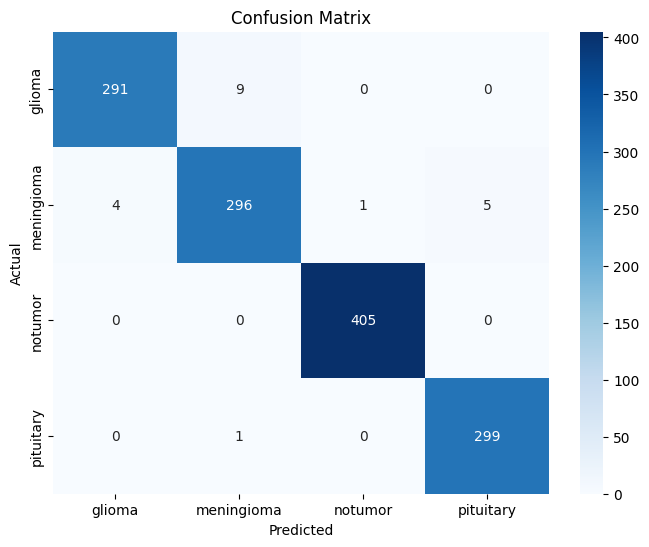

In [3]:
# Step 6: Evaluate Model
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print(classification_report(test_labels, y_pred_classes, zero_division=1))

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["glioma", "meningioma", "notumor", "pituitary"],
            yticklabels=["glioma", "meningioma", "notumor", "pituitary"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

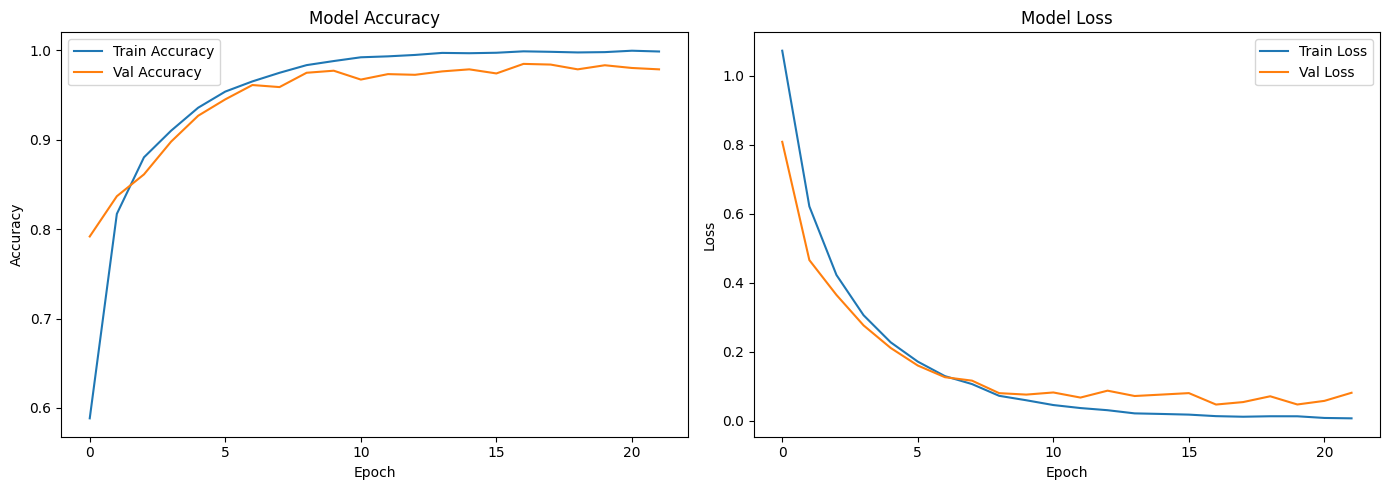

In [5]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step


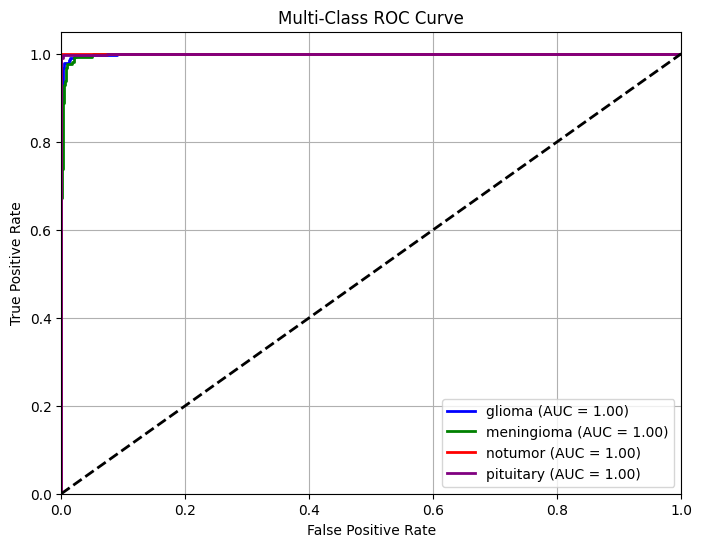

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

# Binarize labels
n_classes = 4
y_test_bin = label_binarize(test_labels, classes=[0, 1, 2, 3])
y_pred_probs = model.predict(test_images)

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'purple']
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [7]:
from sklearn.metrics import accuracy_score
pred_probs = model.predict(test_images)
pred_labels = np.argmax(pred_probs, axis=1)
acc = accuracy_score(test_labels, pred_labels)
print(f"Test Accuracy: {acc:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step
Test Accuracy: 0.9847


In [8]:
train_loss, train_accuracy = model.evaluate(train_images, train_labels, verbose=0)
print(f"Training Accuracy: {train_accuracy:.2%}")


Training Accuracy: 100.00%


In [9]:
from sklearn.metrics import f1_score
overall_f1 = f1_score(test_labels, y_pred_classes, average='weighted')  # Weighted F1 score across all classes
print(f"\nOverall Weighted F1 Score: {overall_f1:.4f}")


Overall Weighted F1 Score: 0.9847


In [10]:
from sklearn.metrics import recall_score
overall_sensitivity = recall_score(test_labels, y_pred_classes, average='weighted')  # Weighted Recall across all classes
print(f"\nOverall Weighted Sensitivity (Recall): {overall_sensitivity:.4f}")


Overall Weighted Sensitivity (Recall): 0.9847


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


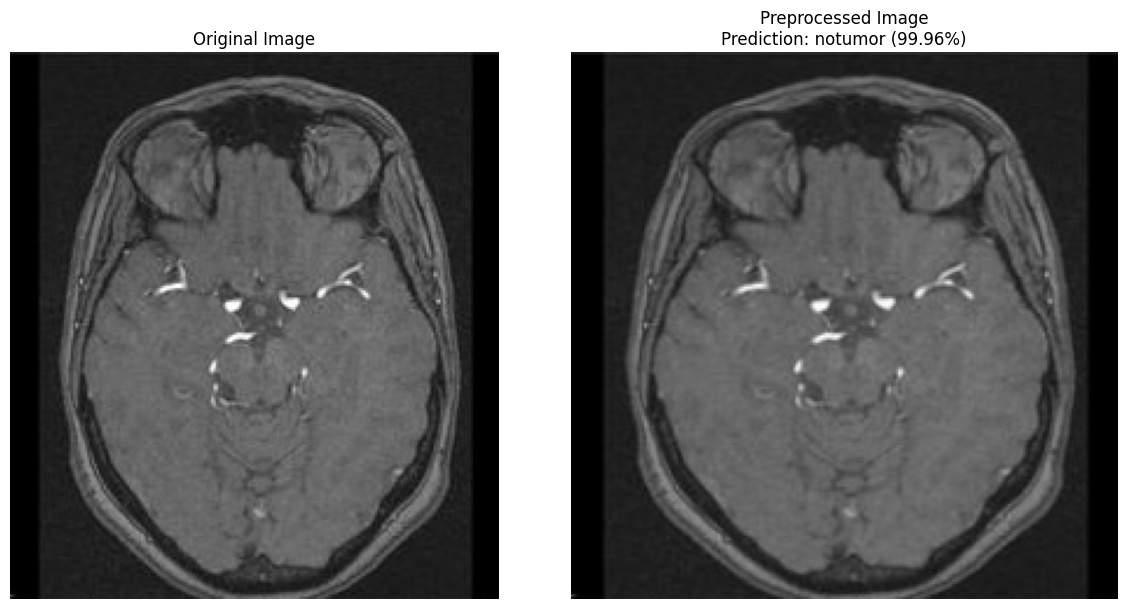

Class Probabilities:
glioma: 0.01%
meningioma: 0.02%
notumor: 99.96%
pituitary: 0.01%


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Class names for predictions
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

def preprocess_and_predict(image_path, model, img_size=(224, 224)):
    # Step 1: Load image
    original_bgr = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

    # Step 2: Resize and normalize
    resized_rgb = cv2.resize(original_rgb, img_size)
    normalized = resized_rgb / 255.0

    # Step 3: Expand dimensions for prediction
    input_image = np.expand_dims(normalized, axis=0)  # Shape: (1, 224, 224, 3)

    # Step 4: Model Prediction
    prediction = model.predict(input_image)[0]  # Shape: (4,)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = class_names[predicted_class_idx]
    confidence = prediction[predicted_class_idx] * 100

    # Step 5: Display images side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(original_rgb)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(normalized)
    axs[1].set_title(f"Preprocessed Image\nPrediction: {predicted_class} ({confidence:.2f}%)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    # Step 6: Print class probabilities
    print("Class Probabilities:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: {prediction[i]*100:.2f}%")

# Example usage
image_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0024.jpg"
preprocess_and_predict(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


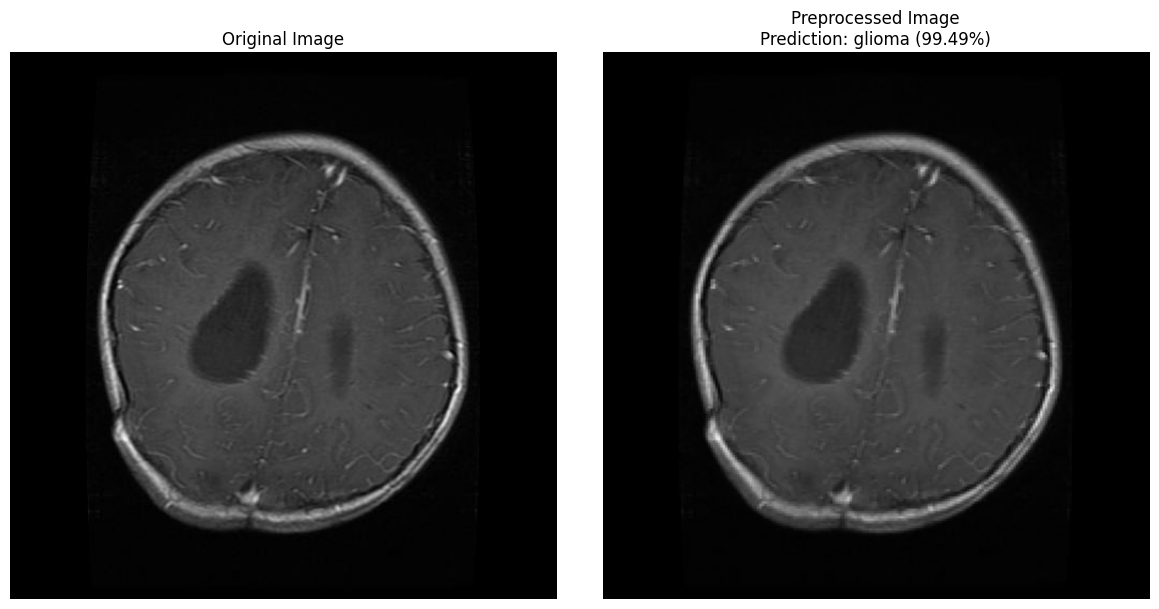

Class Probabilities:
glioma: 99.49%
meningioma: 0.12%
notumor: 0.25%
pituitary: 0.13%


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Class names for predictions
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

def preprocess_and_predict(image_path, model, img_size=(224, 224)):
    # Step 1: Load image
    original_bgr = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

    # Step 2: Resize and normalize
    resized_rgb = cv2.resize(original_rgb, img_size)
    normalized = resized_rgb / 255.0

    # Step 3: Expand dimensions for prediction
    input_image = np.expand_dims(normalized, axis=0)  

    # Step 4: Model Prediction
    prediction = model.predict(input_image)[0]  
    predicted_class_idx = np.argmax(prediction)
    predicted_class = class_names[predicted_class_idx]
    confidence = prediction[predicted_class_idx] * 100

    # Step 5: Display images side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(original_rgb)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(normalized)
    axs[1].set_title(f"Preprocessed Image\nPrediction: {predicted_class} ({confidence:.2f}%)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    # Step 6: Print class probabilities
    print("Class Probabilities:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: {prediction[i]*100:.2f}%")

# Example usage
image_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0018.jpg"
preprocess_and_predict(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


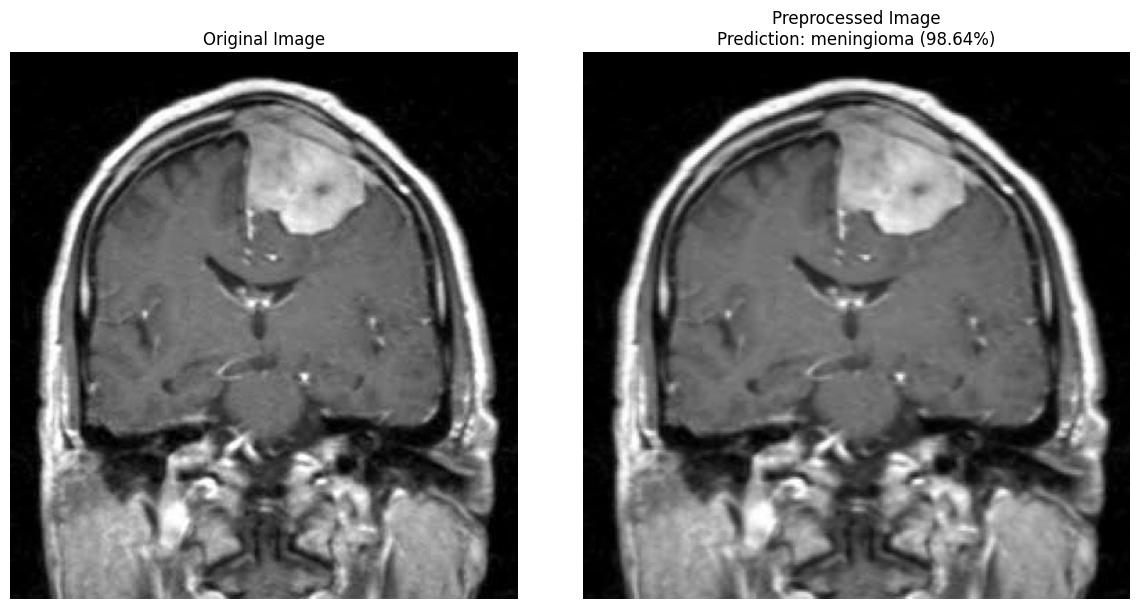

Class Probabilities:
glioma: 0.12%
meningioma: 98.64%
notumor: 0.20%
pituitary: 1.04%


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Class names for predictions
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

def preprocess_and_predict(image_path, model, img_size=(224, 224)):
    # Step 1: Load image
    original_bgr = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

    # Step 2: Resize and normalize
    resized_rgb = cv2.resize(original_rgb, img_size)
    normalized = resized_rgb / 255.0

    # Step 3: Expand dimensions for prediction
    input_image = np.expand_dims(normalized, axis=0)  

    # Step 4: Model Prediction
    prediction = model.predict(input_image)[0]  
    predicted_class_idx = np.argmax(prediction)
    predicted_class = class_names[predicted_class_idx]
    confidence = prediction[predicted_class_idx] * 100

    # Step 5: Display images side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(original_rgb)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(normalized)
    axs[1].set_title(f"Preprocessed Image\nPrediction: {predicted_class} ({confidence:.2f}%)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    # Step 6: Print class probabilities
    print("Class Probabilities:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: {prediction[i]*100:.2f}%")

# Example usage
image_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0054.jpg"
preprocess_and_predict(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


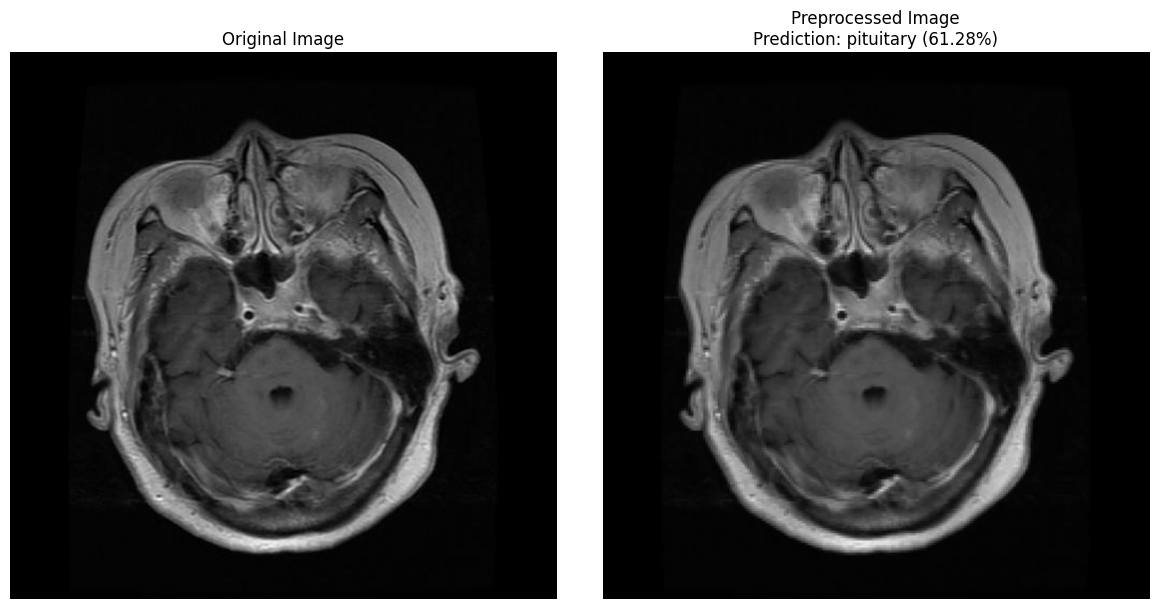

Class Probabilities:
glioma: 2.79%
meningioma: 35.20%
notumor: 0.73%
pituitary: 61.28%


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Class names for predictions
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

def preprocess_and_predict(image_path, model, img_size=(224, 224)):
    # Step 1: Load image
    original_bgr = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

    # Step 2: Resize and normalize
    resized_rgb = cv2.resize(original_rgb, img_size)
    normalized = resized_rgb / 255.0

    # Step 3: Expand dimensions for prediction
    input_image = np.expand_dims(normalized, axis=0)  

    # Step 4: Model Prediction
    prediction = model.predict(input_image)[0]  
    predicted_class_idx = np.argmax(prediction)
    predicted_class = class_names[predicted_class_idx]
    confidence = prediction[predicted_class_idx] * 100

    # Step 5: Display images side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(original_rgb)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(normalized)
    axs[1].set_title(f"Preprocessed Image\nPrediction: {predicted_class} ({confidence:.2f}%)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    # Step 6: Print class probabilities
    print("Class Probabilities:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: {prediction[i]*100:.2f}%")

# Example usage
image_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0029.jpg"
preprocess_and_predict(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


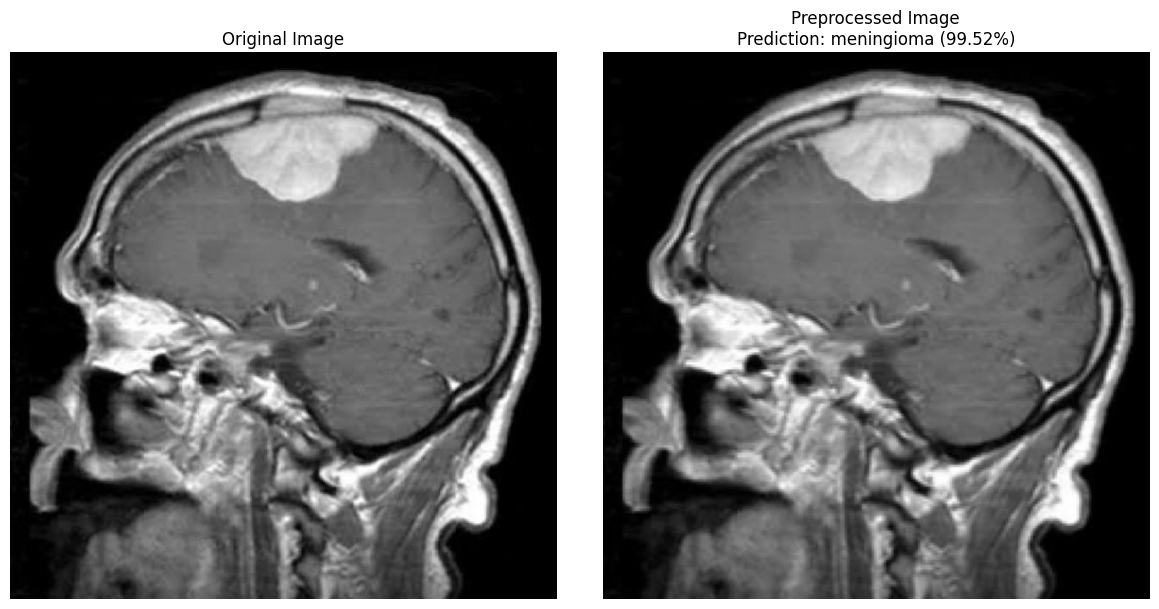

Class Probabilities:
glioma: 0.17%
meningioma: 99.52%
notumor: 0.13%
pituitary: 0.18%


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Class names for predictions
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

def preprocess_and_predict(image_path, model, img_size=(224, 224)):
    # Step 1: Load image
    original_bgr = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

    # Step 2: Resize and normalize
    resized_rgb = cv2.resize(original_rgb, img_size)
    normalized = resized_rgb / 255.0

    # Step 3: Expand dimensions for prediction
    input_image = np.expand_dims(normalized, axis=0)  

    # Step 4: Model Prediction
    prediction = model.predict(input_image)[0]  
    predicted_class_idx = np.argmax(prediction)
    predicted_class = class_names[predicted_class_idx]
    confidence = prediction[predicted_class_idx] * 100

    # Step 5: Display images side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(original_rgb)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(normalized)
    axs[1].set_title(f"Preprocessed Image\nPrediction: {predicted_class} ({confidence:.2f}%)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    # Step 6: Print class probabilities
    print("Class Probabilities:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: {prediction[i]*100:.2f}%")

# Example usage
image_path = "/kaggle/input/sample/samplemeningioma.jpg"
preprocess_and_predict(image_path, model)


In [17]:
def load_unseen_data(unseen_path, img_size=(224, 224)):
    images, labels = [], []
    class_labels = {"glioma_tumor": 0, "meningioma_tumor": 1, "no_tumor": 2, "pituitary_tumor": 3}

    for folder in os.listdir(unseen_path):
        folder_path = os.path.join(unseen_path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith(('.jpg', '.png')):
                    img = cv2.imread(os.path.join(folder_path, file))
                    img = cv2.resize(img, img_size) / 255.0
                    images.append(img)
                    labels.append(class_labels.get(folder, -1))

    images, labels = np.array(images), np.array(labels)
    return images[labels != -1], labels[labels != -1]
unseen_path = "/kaggle/input/brain-tumor-classification-mri/Training"
unseen_images, unseen_labels = load_unseen_data(unseen_path)

loss, acc = model.evaluate(unseen_images, unseen_labels)
print(f"Unseen Data Accuracy: {acc:.4f}, Loss: {loss:.4f}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.9971 - loss: 0.0108
Unseen Data Accuracy: 0.9889, Loss: 0.0331


In [18]:
def load_unseen_data(unseen_path, img_size=(224, 224)):
    images, labels = [], []
    class_labels = {"glioma": 0, "meningioma": 1, "notumor": 2, "pituitary": 3}

    for folder in os.listdir(unseen_path):
        folder_path = os.path.join(unseen_path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith(('.jpg', '.png')):
                    img = cv2.imread(os.path.join(folder_path, file))
                    img = cv2.resize(img, img_size) / 255.0
                    images.append(img)
                    labels.append(class_labels.get(folder, -1))

    images, labels = np.array(images), np.array(labels)
    return images[labels != -1], labels[labels != -1]
unseen_path = "/kaggle/input/labeled-mri-brain-tumor-dataset/Brain Tumor labeled dataset"
unseen_images, unseen_labels = load_unseen_data(unseen_path)

loss, acc = model.evaluate(unseen_images, unseen_labels)
print(f"Unseen Data Accuracy: {acc:.4f}, Loss: {loss:.4f}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 1.0000 - loss: 7.5839e-04
Unseen Data Accuracy: 1.0000, Loss: 0.0011


In [ ]:
def load_first_50_images(unseen_path, img_size=(224, 224)):
    images = []
    filenames = []

    files = [f for f in os.listdir(unseen_path) if f.endswith(('.jpg', '.png'))]
    files = sorted(files)[:10]  

    for file in files:
        img = cv2.imread(os.path.join(unseen_path, file))
        img = cv2.resize(img, img_size) / 255.0
        images.append(img)
        filenames.append(file)

    return np.array(images), filenames

# Path to your unlabeled image folder
unseen_path = "/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images/Healthy"
unseen_images, filenames = load_first_50_images(unseen_path)

# Predict using the trained model
predictions = model.predict(unseen_images)
predicted_classes = np.argmax(predictions, axis=1)

# Print predictions
for file, pred in zip(filenames, predicted_classes):
    print(f"{file}: Predicted Class = {class_names[pred]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
mri_healthy (1).jpg: Predicted Class = notumor
mri_healthy (10).jpg: Predicted Class = notumor
mri_healthy (100).jpg: Predicted Class = notumor
mri_healthy (1000).jpg: Predicted Class = notumor
mri_healthy (1001).jpg: Predicted Class = pituitary
mri_healthy (1002).jpg: Predicted Class = notumor
mri_healthy (1003).jpg: Predicted Class = notumor
mri_healthy (1004).jpg: Predicted Class = notumor
mri_healthy (1005).jpg: Predicted Class = notumor
mri_healthy (1006).jpg: Predicted Class = notumor


In [ ]:
import os
import cv2
import numpy as np


class_names = {0: "glioma", 1: "meningioma", 2: "notumor", 3: "pituitary"}

def load_unlabeled_images(unseen_path, img_size=(224, 224)):
    images = []
    filenames = []

    for file in os.listdir(unseen_path):
        if file.endswith(('.jpg', '.png')):
            img = cv2.imread(os.path.join(unseen_path, file))
            img = cv2.resize(img, img_size) / 255.0
            images.append(img)
            filenames.append(file)

    return np.array(images), filenames

# Path to the folder with unlabeled images
unseen_path = "/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images/Tumor"
unseen_images, filenames = load_unlabeled_images(unseen_path)

# Predict classes
predictions = model.predict(unseen_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display predictions
for file, pred in zip(filenames, predicted_classes):
    print(f"{file}: Predicted Class = {class_names[pred]}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step
tumor (243).jpg: Predicted Class = meningioma
meningioma (1062).jpg: Predicted Class = meningioma
pituitary (205).jpg: Predicted Class = pituitary
meningioma (95).jpg: Predicted Class = meningioma
glioma (123).jpg: Predicted Class = glioma
tumor (281).jpg: Predicted Class = meningioma
glioma (498).jpg: Predicted Class = glioma
glioma (453).jpg: Predicted Class = glioma
meningioma (494).jpg: Predicted Class = meningioma
meningioma (682).jpg: Predicted Class = meningioma
meningioma (589).jpg: Predicted Class = meningioma
tumor (237).jpg: Predicted Class = meningioma
tumor (202).jpg: Predicted Class = meningioma
glioma (10).jpg: Predicted Class = glioma
meningioma (447).jpg: Predicted Class = meningioma
glioma (179).jpg: Predicted Class = glioma
meningioma (715).jpg: Predicted Class = meningioma
glioma (352).jpg: Predicted Class = glioma
meningioma (576).jpg: Predicted Class = meningioma
pituitary (358).jpg: Predicted Class = pituitary
pituitary (

In [ ]:
def load_first_50_images(unseen_path, img_size=(224, 224)):
    images = []
    filenames = []

    files = [f for f in os.listdir(unseen_path) if f.endswith(('.jpg', '.png'))]
    files = sorted(files)[:50]  

    for file in files:
        img = cv2.imread(os.path.join(unseen_path, file))
        img = cv2.resize(img, img_size) / 255.0
        images.append(img)
        filenames.append(file)

    return np.array(images), filenames

# Path to your unlabeled image folder
unseen_path = "/kaggle/input/brain-tumor-classification-mri-images/test_images-20210704T210303Z-001/test_images"
unseen_images, filenames = load_first_50_images(unseen_path)

# Predict using the trained model
predictions = model.predict(unseen_images)
predicted_classes = np.argmax(predictions, axis=1)

# Print predictions
for file, pred in zip(filenames, predicted_classes):
    print(f"{file}: Predicted Class = {class_names[pred]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1.jpg: Predicted Class = meningioma
test1.jpg: Predicted Class = meningioma
test10.jpg: Predicted Class = glioma
test11.jpg: Predicted Class = pituitary
test12.jpg: Predicted Class = meningioma
test2.jpg: Predicted Class = meningioma
test3.jpg: Predicted Class = meningioma
test4.jpg: Predicted Class = pituitary
test5.jpg: Predicted Class = meningioma
test6.jpg: Predicted Class = pituitary
test7.jpg: Predicted Class = glioma
test8.jpg: Predicted Class = meningioma
test9.jpg: Predicted Class = meningioma
